# Multivariate LSTM Time Series Model for Adj Close Price Forecasting 
* High
* Low
* Open
* Close
* Volume
* Adj Close

In [3]:
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from IPython.display import clear_output
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### Data Parsing & Plotting

In [4]:
def plot_ticker(df):

    fig = plt.figure(figsize=(10, 5))
    plt.plot(df.index, df["High"], label = 'High')
    plt.plot(df.index, df["Low"], label = 'Low')
    plt.plot(df.index, df["Open"], label = 'Open')
    plt.plot(df.index, df["Close"], label = 'Close')
    plt.plot(df.index, df["Adj Close"], label = 'Adj Close')

    plt.xticks(rotation=45, color='teal', size=12)
    plt.yticks(rotation=45, color='teal', size=12)

    plt.xlabel('Dates', {'color': 'orange', 'fontsize':12})
    plt.ylabel('Prices', {'color': 'orange', 'fontsize':12})

    plt.title(str(symbol.upper())+' '+'Prices', color='purple', size=20)

    # Plotting the horizontal line for min & max values along with the adj close prices
    max_price = np.round(np.max(df['Adj Close']),3)
    min_price = np.round(np.min(df['Adj Close']),3)
    plt.axhline(max_price, color='r', linestyle='dashed')
    plt.axhline(min_price, color='b', linestyle='dashed')
    
    # coordinate for the text position (x-axis)
    coord = datetime.strptime(end_date,'%Y%m%d')
    coord = coord - relativedelta(months=3)
    # y-axis = max and min prices + 3
    plt.text(coord, max_price+5, 'Max = $'+str(max_price), size=12, color='r')
    plt.text(coord, min_price+5, 'Min = $'+str(min_price), size=12, color='b')
    
    plt.legend()
    plt.grid(True)

    plt.show()

In [5]:
def ticker_info(): 
    global symbol, end_date, start_date

    end_date = input("Set a date (yyyymmdd):")
    time_gap = input("years gap:")
    start_date = str(int(end_date) - (int(time_gap) * 10000))
    
    symbol = input("Symbol:")
    ticker_df = pdr.get_data_yahoo(symbol, start_date, end_date) 
    
    plot_ticker(ticker_df[ticker_df.columns.difference(["Volume"])])
    
    return ticker_df 

Set a date (yyyymmdd):20220119
years gap:4
Symbol:TSLA


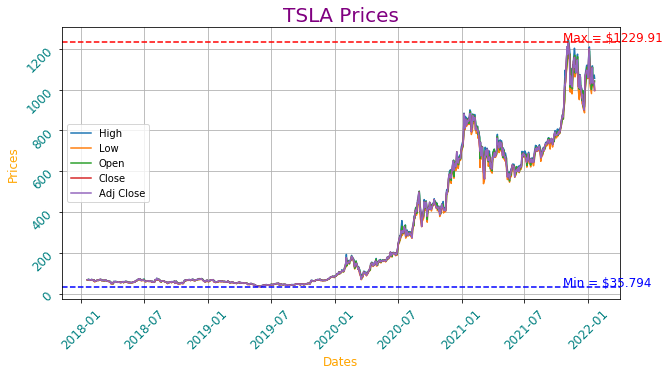

In [6]:
ticker_df = ticker_info()

### Preprocessing Data Set

In [7]:
# Scaling the adj close price values 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(ticker_df)

In [8]:
# train test split
train_size = int(len(scaled_df)*0.8)
test_size = len(scaled_df)-train_size
train_df, test_df = scaled_df[0:train_size], scaled_df[train_size:] 
print(len(scaled_df),"=",train_size," + ",test_size)

1008 = 806  +  202


In [9]:
# assign X and Y based on time steps
def assign(data, timestep = None):
    X, y = [],[]
    
    if timestep == None:
        default_timestep = 10
        for i in range(len(data)-default_timestep-1):
            values_X = data[i:(i+default_timestep)]
            values_y = data[i+default_timestep,5]
            
            X.append(values_X)
            y.append(values_y)
        
    else:
        for i in range(len(data)-timestep-1):  
            values_X = data[i:(i+timestep)]
            values_y = data[i+timestep,5]
            
            X.append(values_X)
            y.append(values_y)
    
    return np.array(X), np.array(y)


In [10]:
timestep=100

X_train, y_train = assign(train_df, timestep)
X_test, y_test = assign(test_df, timestep)

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(705, 100, 6) (705, 1)
(101, 100, 6) (101, 1)


### Building Stacked LSTM Model

In [12]:
# LSTM Params
# Activation: tanh
# Recurrent Activation: sigmoid
# Dropout: 0
# Output D: 50

# Output Dense Params
# Activation: Linear
# Output D: 1
config = {'loss':'mean_squared_error',
          'optimizer':'adam', 
          'epoch':100,
          'batch_size':32, 
          'metric':'mse',
          'verbose':1}

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(y_train.shape[1]))

model.compile(loss = config['loss'], 
              optimizer = config['optimizer'],
              metrics=[config['metric']])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           11400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 51,851
Trainable params: 51,851
Non-trainable params: 0
_________________________________________________________________


In [13]:
# customized callback
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.metric = []
        self.val_metric = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.metric.append(logs.get(config['metric']))
        self.val_metric.append(logs.get('val_'+config['metric']))
        self.i += 1
        
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        fig.set_size_inches(10.5, 7.5)
        fig.suptitle('Processing',size = 20)
        clear_output(wait=True)
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="Loss")
        ax1.plot(self.x, self.val_losses, label="Valid Loss")
        ax1.legend()
        
        
        ax2.plot(self.x, self.metric, label="Train_"+config['metric'])
        ax2.plot(self.x, self.val_metric, label="Valid_"+config['metric'])
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

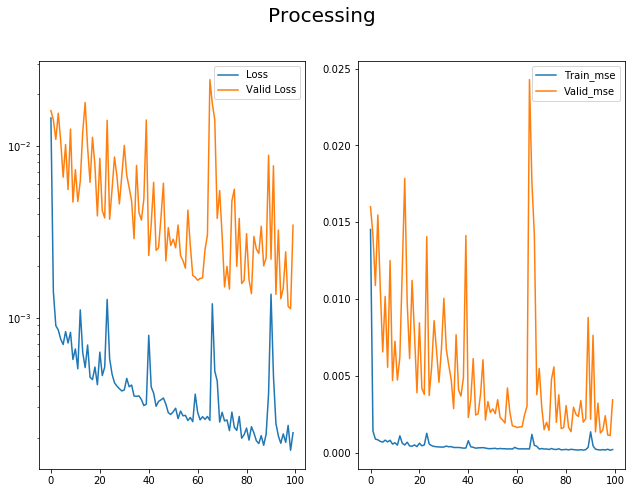

23/23 [==============================] - 2s 84ms/step - loss: 2.1372e-04 - mse: 2.1372e-04 - val_loss: 0.0035 - val_mse: 0.0035


In [14]:
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=config["epoch"], 
                    batch_size=config["batch_size"],
                    verbose=config['verbose'],
                    callbacks=[plot])

### Evaluation 
* Root Mean Squared Error
* Mean Absolute Percentage Error

In [15]:
# Predict train & test sets
train_pred = model.predict(X_train)
train_pred_copies = np.repeat(train_pred, train_df.shape[1], axis=1) # Adjust the shape of the output
train_pred_inverse = scaler.inverse_transform(train_pred_copies)[:,0] # Scale back the normalized output

y_train_copies = np.repeat(y_train, train_df.shape[1], axis=1) # Adjust the shape of the output
y_train_inverse = scaler.inverse_transform(y_train_copies)[:,0] # Scale back the normalized output

test_pred = model.predict(X_test)
test_pred_copies = np.repeat(test_pred, test_df.shape[1], axis=1) # Adjust the shape of the output
test_pred_inverse = scaler.inverse_transform(test_pred_copies)[:,0] # Scale back the normalized output

y_test_copies = np.repeat(y_test, test_df.shape[1], axis=1) # Adjust the shape of the output
y_test_inverse = scaler.inverse_transform(y_test_copies)[:,0] # Scale back the normalized output

In [16]:
# Root Mean Squared Error for train & test sets

rmse_train = math.sqrt(mean_squared_error(y_train_inverse, train_pred_inverse))
rmse_test = math.sqrt(mean_squared_error(y_test_inverse, test_pred_inverse))
print('RMSE for train: %0.2f' % rmse_train)
print('RMSE for test: %0.2f' % rmse_test)

RMSE for train: 19.11
RMSE for test: 70.86


In [17]:
# Mean Absolute Percentage Error

mape_train = math.sqrt(mean_absolute_percentage_error(y_train_inverse, train_pred_inverse))
mape_test = math.sqrt(mean_absolute_percentage_error(y_test_inverse, test_pred_inverse))
print('MAPE for train: %0.2f' % mape_train)
print('MAPE for test: %0.2f' % mape_test)

MAPE for train: 0.28
MAPE for test: 0.24


In [ ]:
# create an array for train prediction values
timesteps = 100
train_prediction_array = np.empty_like(scaled_df)
train_prediction_array[:,] = np.nan
train_prediction_array[timesteps : len(y_train)+timesteps, ] = train_pred_inverse

# create an array for test prediction values
test_prediction_array = np.empty_like(scaled_df)
test_prediction_array[:,] = np.nan
test_prediction_array[len(y_train)+(timesteps*2)+1 : len(scaled_df)-1, ] = test_pred_inverse

# plot baseline and predictions
plt.figure(figsize=(11,6))

plt.xticks(rotation=45, size=12)
plt.yticks(rotation=45, size=12)

plt.xlabel('Dates', size = 14)
plt.ylabel('Price', size = 14)
plt.title('Adj Close Price Prediction', size=20)

plt.plot(adjClose_df.index, scaler.inverse_transform(scaled_df), label = "Original Prices")
plt.plot(adjClose_df.index, train_prediction_array, label = "Train Prediction")
plt.plot(adjClose_df.index, test_prediction_array, label = "Test Prediction")

plt.grid(True)
plt.legend()
plt.show()